$\displaystyle{
}$

$\displaystyle{
\begin{align*}
\end{align*}
}$

### [Решaющий пень](#Решающий-пень)
### [Опечaтки](#Опечатки)
### [Points in a circle generatоr](#Points-in-a-circle-generator)
### [Суммa на гранях](#Сумма-на-гранях)
### [Стaуэтки](#Статуэтки)
### [Пирaмиды](#Пирамиды)
### [Восстaновление коэффициентов](#Восстановление-коэффициентов)

In [1]:
from __future__ import annotations
import catboost
import dataclasses
import functools
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import scipy
import sklearn.decomposition
import sklearn.linear_model
import subprocess
import string
import sys
import torch
import torch.nn as nn
import time
import typing as tp

In [2]:
def run_executable(path: str, arguments: str = "", input_: str = "") -> str:
    completed_process = subprocess.run(
        [path, arguments], input=input_, text=True, capture_output=True
    )
    output = completed_process.stdout
    return output


def factorial(n):
    factorial = 1
    for i in range(1, n + 1):
        factorial *= i
    return factorial


def get_pairwise_difference_matrix(array):
    """Returns matrix M[i, j] = a[i] - a[j]."""
    pairwise_difference_matrix = array[:, None] - array[None, :]
    return pairwise_difference_matrix


def permute(array, first, second):
    array[first], array[second] = array[second], array[first]

In [3]:
CPP_DIR = "/Users/dimakoshman/CLionProjects/coderun_ml/cmake-build-debug"

In [4]:
@dataclasses.dataclass
class Timer:
    enter_time: list[float] = dataclasses.field(default_factory=list)
    exit_time: list[float] = dataclasses.field(default_factory=list)

    def __enter__(self):
        self.enter_time.append(time.time())
        return self

    def __exit__(self, *args, **kwargs):
        self.exit_time.append(time.time())

    def wrap(self, function: tp.Callable) -> tp.Callable:
        @functools.wraps(function)
        def wrapper(*args, **kwargs):
            with self:
                return function(*args, **kwargs)

        return wrapper

    def stats(self) -> dict[str, float]:
        timings = [a - b for a, b in zip(self.exit_time, self.enter_time, strict=True)]
        stats = dict(mean=np.mean(timings), std=np.std(timings), max=max(timings))
        return stats

    def formatted_stats(
        self, time_unit: tp.Literal["ms", "s"] = "ms", precision: int = 3
    ) -> str:
        formatted_stats: list[str] = []
        for k, v in self.stats().items():
            match time_unit:
                case "ms":
                    v *= 1000
                case "s":
                    pass
                case _:
                    raise ValueError(f"Unknown time unit {time_unit}.")
            formatted_stats.append(f"\t{k}:\t{v:.{precision}f} {time_unit}")

        formatted_stats = "\n".join(formatted_stats)
        return formatted_stats

In [5]:
@dataclasses.dataclass
class Input:
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> "Input":
        raise NotImplementedError


@dataclasses.dataclass
class Output:
    @staticmethod
    def from_string_io(string_io: io.StringIO) -> "Output":
        raise NotImplementedError

    def __str__(self):
        raise NotImplementedError

    def __eq__(self, output: "Output"):
        raise NotImplementedError


def generate_random_input(test_case: int) -> Input | tp.Tuple[Input, Output]:
    raise NotImplementedError


def generate_stress_input() -> Input:
    raise NotImplementedError


def brute_force_solve(input_: Input) -> Output:
    raise NotImplementedError


def solve(input_: Input) -> Output:
    raise NotImplementedError


def cpp_solve(input_: Input) -> Output:
    raise NotImplementedError


def check(
    solve: tp.Callable,
    input_: Input | str,
    expected_ouput: Output | str | None = None,
) -> None:
    if isinstance(input_, str):
        input_ = Input.from_string_io(io.StringIO(input_))

    output = solve(input_)

    if isinstance(expected_ouput, str):
        expected_ouput = Output.from_string_io(io.StringIO(expected_ouput))
    if expected_ouput is not None and output != expected_ouput:
        raise RuntimeError(
            f"Wrong answer, expected output:\n{expected_ouput}\nReceived:\n{output}"
        )

    try:
        brute_force_ouput = brute_force_solve(input_)
    except NotImplementedError:
        pass
    else:
        if output != brute_force_ouput:
            raise RuntimeError(
                f"Wrong answer, brute force output:\n{brute_force_ouput}\nReceived:\n{output}"
            )

    try:
        cpp_output = cpp_solve(input_)
    except NotImplementedError:
        pass
    else:
        if output != cpp_output:
            raise RuntimeError(
                f"Wrong answer, cpp output:\n{cpp_output}\nReceived:\n{output}"
            )


def simple_test():
    #     check(solve, """""", """""")
    #     check(solve, """""", """""")
    #     check(solve, """""", """""")

    print("Simple tests OK")


def random_test():
    random_tests_timer = Timer()
    timed_solve = random_tests_timer.wrap(solve)

    for test_case in range(100):
        match generate_random_input(test_case):
            case input_, expected_ouput:
                pass
            case input_:
                expected_ouput = None

        check(solve=timed_solve, input_=input_, expected_ouput=expected_ouput)

    print(f"Random tests OK\n{random_tests_timer.formatted_stats()}")


def stress_test():
    stress_tests_timer = Timer()
    timed_solve = stress_tests_timer.wrap(solve)

    for _ in range(10):
        input_ = generate_stress_input()
        check(solve=timed_solve, input_=input_)

    print(f"Stress tests OK\n{stress_tests_timer.formatted_stats()}")


def test():
    simple_test()
    random_test()
    stress_test()


def main():
    print(solve(Input.from_string_io(sys.stdin)))

### [Решающий пень](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/stump/description?currentPage=1&pageSize=10&rowNumber=6&compiler=python-ml)


<img src="media/decision_stump.png" width="600">

Let $x_i \leq x_{i+1}$.

$\displaystyle{
\begin{align*}
\text{loss} = 
\sum_i (f(x_i) - y_i)^2 =
\sum_i (a\mathbb{1}[x_i < c] + b\mathbb{1}[x_i \geq c] - y_i)^2 =
\sum_i (a\mathbb{1}[i < d] + b\mathbb{1}[i \geq d] - y_i)^2
\end{align*}
}$

Where $x_d = c$.

$\displaystyle{
\frac{d}{da} = 
2\sum_i \mathbb{1}[i < d](a\mathbb{1}[i < d] + b\mathbb{1}[i \geq d] - y_i) = 
2\sum_i \mathbb{1}[i < d](a - y_i) =
2(da - \sum_{i < d} y_i) = 0 \\
a = a_d = \frac{\sum_{i < d} y_i}{d} \\
b = b_d = \frac{\sum_{i \geq d} y_i}{n - d}\\
}$

Let's compute losses for each $d = 0\dots n-1$, dynamically recomputing losses while incrementing i:

$\displaystyle{
d = 0\\
\text{loss}_0 = 
\text{loss}_{<0} + \text{loss}_{\geq 0} =
\sum_i (\overline{y} - y_i)^2
}$

$\displaystyle{
d \rightarrow d + 1\\
\text{loss}_{d+1} = 
\text{loss}_{<d + 1} + \text{loss}_{\geq d+ 1}
}$

$\displaystyle{
\begin{align*}
\text{loss}_{<d+1} = 
& \sum_{i < d+1} (a_{d+1} - y_i)^2 =\\=
& \sum_{i < d+1} \left(\frac{\sum_{j < d+1} y_j}{d+1} - y_i\right)^2 =\\=
& \sum_{i < d+1} \left(\frac{da_d + y_{d}}{d+1} - y_i\right)^2 =\\=
& \frac{1}{(d+1)^2}\sum_{i < d+1} \left(d (a_d - y_i) + y_{d} - y_i\right)^2 =\\=
& \frac{1}{(d+1)^2}\sum_{i < d+1} \left(d^2 (a_d - y_i)^2 + 2d(a_d - y_i)(y_{d} - y_i) + (y_{d} - y_i)^2\right) =\\=
& \frac{1}{(d+1)^2}\sum_{i < d+1}\left(
d^2(a_d - y_i)^2 + 2da_dy_{d} - 2dy_iy_{d} - 2da_dy_i +2dy_i^2 + y_{d}^2 -2y_{d} y_i + y_i^2
\right) =\\=
& \frac{1}{(d+1)^2}\left(
d^2\sum_{i < d+1}(a_d - y_i)^2 +
\sum_{i < d+1}\left(2da_dy_{d} + y_{d}^2\right) +
\sum_{i < d+1}y_i \left( - 2dy_{d} - 2da_d -2y_{d}\right) +
(2d + 1)\sum_{i < d+1}y_i^2
\right) =\\=
& \frac{1}{(d+1)^2}\left(
d^2\text{loss}_{<d} + (da_d - dy_{d})^2 +
(d+1)\left(2da_dy_{d} + y_{d}^2\right)
 - 2 \left(dy_{d } + da_d + y_{d}\right) \sum_{i < d+1}y_i +
(2d + 1)\sum_{i < d+1}y_i^2
\right)
\end{align*}
}$

$\displaystyle{
\begin{align*}
\text{loss}_{\geq d+1} = 
& \sum_{i \geq d+1} (b_{d+1} - y_i)^2 =\\=
& \sum_{i \geq d+1} \left(\frac{\sum_{i \geq d+1} y_i}{n - d - 1} - y_i\right)^2 =\\=
& \sum_{i \geq d+1} \left(\frac{b_d(n-d) - y_d - y_i(n-d-1)}{n-d-1}\right)^2 =\\=
& \sum_{i \geq d+1} \left(\frac{(n-d)(b_d - y_i) + y_i - y_d}{n-d-1}\right)^2 =\\=
& \frac{1}{(n-d-1)^2}\sum_{i \geq d+1} \left((n-d)^2(b_d - y_i)^2 + 2(n-d)(b_d - y_i)(y_i - y_d) +(y_i - y_d)^2
\right) =\\=
& \frac{1}{(n-d-1)^2}\left((n-d)^2(\text{loss}_{\geq d} - (b_d - y_d)^2)  + 2(n-d)\sum_{i \geq d+1}(b_d - y_i)(y_i - y_d) + \sum_{i \geq d+1}(y_i - y_d)^2
\right) =\\=
& \frac{1}{(n-d-1)^2}\left((n-d)^2\text{loss}_{\geq d} - ((n-d)b_d - (n-d)y_d)^2  + (n-d-1)(y_d^2 - 2(n-d)b_d y_d) +\\
+2((n-d) (b_d + y_d) - y_d)\sum_{i \geq d+1} y_i +
(1 - 2(n-d))\sum_{i \geq d+1} y_i^2
\right)
\end{align*}
}$

In [492]:
@dataclasses.dataclass
class Input:
    x: tp.List[int] = dataclasses.field(default_factory=list)
    y: tp.List[int] = dataclasses.field(default_factory=list)

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        input_ = Input()
        n = int(string_io.readline())

        for _ in range(n):
            x, y = map(int, string_io.readline().split())
            input_.x.append(x)
            input_.y.append(y)

        return input_

    def __str__(self) -> str:
        string = ""
        string += str(len(self.x)) + "\n"
        string += "".join(f"{x} {y}\n" for x, y in zip(self.x, self.y))
        return string


@dataclasses.dataclass
class Output:
    a: float
    b: float
    c: float

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        a, b, c = map(float, string_io.readline().split())
        output = Output(a=a, b=b, c=c)
        return output

    def __str__(self) -> str:
        string = f"{self.a:.6f} {self.b:.6f} {self.c:.6f}"
        return string

    def __eq__(self, output: Output) -> bool:
        eq = all(np.isclose([self.a, self.b], [output.a, output.b]))
        return eq


def brute_force_solve(input_: Input) -> Output:
    x = np.array(input_.x)
    y = np.array(input_.y)
    indices = np.argsort(x)
    x = x[indices]
    y = y[indices]
    n = len(x)
    a = 0
    b = 0
    c = 0
    min_loss = np.inf

    for i in range(n):
        if i > 0 and x[i - 1] == x[i]:
            continue
        left_loss = 0 if i == 0 else np.var(y[:i]) * i
        right_loss = np.var(y[i:]) * (n - i)
        loss = left_loss + right_loss

        if loss < min_loss:
            min_loss = loss
            a = 0 if i == 0 else np.mean(y[:i])
            b = np.mean(y[i:])
            c = x[i]

    ouput = Output(a=a, b=b, c=c)
    return ouput


def solve(input_: Input) -> Output:
    if len(input_.x) == 0:
        return Output(0, 0, 0)

    x = np.array(input_.x)
    y = np.array(input_.y)
    indices = np.argsort(x)
    x = x[indices]
    y = y[indices]
    n = len(x)
    left_loss = 0
    left_sum = 0
    left_squared_sum = 0
    right_loss = n * np.var(y)
    right_sum = y.sum()
    right_squared_sum = (y**2).sum()
    min_loss = left_loss + right_loss
    a = 0
    b = right_sum / n
    c = x[0]

    for d in range(n - 1):
        left_loss = (
            d**2 * left_loss
            + (left_sum - d * y[d]) ** 2
            + (d + 1) * (y[d] ** 2 + 2 * left_sum * y[d])
            - 2 * (d * y[d] + left_sum + y[d]) * (left_sum + y[d])
            + (1 + 2 * d) * (left_squared_sum + y[d] ** 2)
        ) / (d + 1) ** 2
        r = n - d
        right_loss = (
            r**2 * right_loss
            - (right_sum - r * y[d]) ** 2
            + (r - 1) * (y[d] ** 2 - 2 * right_sum * y[d])
            + 2 * (r * y[d] + right_sum - y[d]) * (right_sum - y[d])
            + (1 - 2 * r) * (right_squared_sum - y[d] ** 2)
        ) / (r - 1) ** 2
        loss = left_loss + right_loss

        left_sum += y[d]
        right_sum -= y[d]
        left_squared_sum += y[d] ** 2
        right_squared_sum -= y[d] ** 2

        if x[d] != x[d + 1] and loss < min_loss:
            min_loss = loss
            a = left_sum / (d + 1)
            b = right_sum / (n - d - 1)
            c = x[d + 1]

    ouput = Output(a=a, b=b, c=c)
    return ouput


def cpp_solve(input_: Input) -> Output:
    output = run_cpp_program(
        os.path.join(CPP_DIR, "decision_stump"), input_=str(input_)
    )
    output = Output.from_string_io(io.StringIO(output))
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [493]:
def generate_random_input(test_case: int) -> Input:
    n = min(10**5, test_case)
    x_max_abs = min(10**9, test_case)
    y_max_abs = min(10**3, test_case)

    x = np.random.randint(-x_max_abs, x_max_abs, n)
    y = np.random.randint(-y_max_abs, y_max_abs, n)

    input_ = Input(x=x, y=y)
    return input_


def generate_stress_input() -> Input:
    return generate_random_input(10**4)


def simple_test():
    check(
        solve,
        """4
        0 1
        1 1
        2 0
        3 0""",
        """1.0000000 0.0000000 1.5000000""",
    )

    check(
        solve,
        """5
        1 2
        3 4
        8 9
        1 100
        3 -12""",
        """51 0.333333 3""",
    )

    print("Simple tests OK")

In [494]:
test()

Simple tests OK
Random tests OK
	mean:	0.206 ms
	std:	0.084 ms
	max:	0.419 ms
Stress tests OK
	mean:	29.620 ms
	std:	0.634 ms
	max:	30.762 ms


### [Опечатки](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/typos?currentPage=1&pageSize=10&rowNumber=1)

<img src="media/typos.png" width="600">

In [495]:
from __future__ import annotations
import dataclasses
import io
import random
import string
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    first: str
    second: str
    substitutions: tp.List[tp.Tuple[str, str]]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        first = string_io.readline().strip()
        second = string_io.readline().strip()
        n = int(string_io.readline())
        substitutions = []

        for _ in range(n):
            sub_from, sub_to = string_io.readline().strip().split()
            substitutions.append((sub_from, sub_to))

        input_ = Input(first=first, second=second, substitutions=substitutions)
        return input_

    def __str__(self) -> str:
        string = "\n".join(
            [self.first, self.second, str(len(self.substitutions))]
            + [f"{f} {t}" for f, t in self.substitutions]
        )
        return string


@dataclasses.dataclass
class Output:
    n_substitutions: int

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        output = Output(n_substitutions=int(string_io.readline()))
        return output

    def __str__(self) -> str:
        string = str(self.n_substitutions)
        return string

    def __eq__(self, output: Output) -> bool:
        return self.n_substitutions == output.n_substitutions


def substitute(strings, substitutions, reverse=False):
    new_strings = []
    for string in strings:
        for sub_from, sub_to in substitutions:
            s = len(sub_from)
            for i in range(len(string) - s + 1):
                if not reverse and string[i : i + s] == sub_from:
                    new_strings.append(string[:i] + sub_to + string[i + s :])
                elif reverse and string[i : i + s] == sub_to:
                    new_strings.append(string[:i] + sub_from + string[i + s :])

    new_strings = set(new_strings)
    return new_strings


def solve(input_: Input) -> Output:
    first = input_.first
    second = input_.second
    if first == second:
        return Output(n_substitutions=0)

    first_subs = substitute([first], input_.substitutions)

    if second in first_subs:
        return Output(n_substitutions=1)

    second_subs = substitute([second], input_.substitutions, reverse=True)

    if len(first_subs & second_subs):
        return Output(n_substitutions=2)

    first_subs = substitute(first_subs, input_.substitutions)

    if len(first_subs & second_subs):
        return Output(n_substitutions=3)

    second_subs = substitute(second_subs, input_.substitutions, reverse=True)

    if len(first_subs & second_subs):
        return Output(n_substitutions=4)
    else:
        return Output(n_substitutions=-1)


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [496]:
def brute_force_solve(input_: Input) -> Output:
    raise NotImplementedError


def cpp_solve(input_: Input) -> Output:
    raise NotImplementedError


def generate_random_input(test_case: int) -> Input:
    string_size = min(20, test_case // 10)
    n_subs = min(50, test_case // 5)
    subs_max_size = min(6, 1 + test_case // 20)

    first = "".join(random.choices(string.ascii_lowercase, k=string_size))
    second = "".join(random.choices(string.ascii_lowercase, k=string_size))

    substitutions = []
    for _ in range(n_subs):
        sub_size = random.randint(1, subs_max_size)
        sub_from = "".join(random.choices(string.ascii_lowercase, k=sub_size))
        sub_to = "".join(random.choices(string.ascii_lowercase, k=sub_size))
        substitutions.append((sub_from, sub_to))

    input_ = Input(first=first, second=second, substitutions=substitutions)
    return input_


def generate_stress_input() -> Input:
    return generate_random_input(1000)


def simple_test():
    check(
        solve,
        """mlax
            drum
            1
            m d
            """,
        "-1",
    )

    check(
        solve,
        """aaaa
            abba
            1
            aa ba
            """,
        "2",
    )

    check(
        solve,
        """mlax
drum
50
l r
mlax gtwt
m d
mlax ujoc
ml pq
m f
ml bf
mlax aruq
mlax nqdd
mlax fglm
mlax bfit
mlax mziq
mla hlb
a u
mlax vmpa
m w
a w
ax ok
mla kqf
m e
x x
ml if
ml gk
l e
mla xrh
m j
a c
a b
m q
ax fr
ml sb
mlax gxxx
x m
mlax hczx
l q
la sv
l g
ax eh
lax mjh
la ec
la pv
ml iq
a q
lax jrs
la qn
lax bjo
l o
a z
l n
a c""",
        "4",
    )

    print("Simple tests OK")

In [497]:
test()

Simple tests OK
Random tests OK
	mean:	0.015 ms
	std:	0.015 ms
	max:	0.069 ms
Stress tests OK
	mean:	0.825 ms
	std:	0.310 ms
	max:	1.273 ms


### [Points in a circle generator](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/points-in-circle?currentPage=1&pageSize=10&rowNumber=2)


<img src="media/points_in_circle_generator.png" width="600">

In [508]:
def generate1():
    a = random.uniform(0, 1)
    b = random.uniform(0, 1)
    return (a * np.cos(2 * np.pi * b), a * np.sin(2 * np.pi * b))


def generate2():
    while True:
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 > 1:
            continue
        return (x, y)

In [536]:
from __future__ import annotations
import dataclasses
import io
import random
import string
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    sets_of_points: tp.List[tp.List[tp.Tuple[float, float]]]
    n_sets: int = 100

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        sets_of_points = []
        for _ in range(100):
            line = string_io.readline()
            points = [float(i) for i in line.split()]
            sets_of_points.append([(x, y) for x, y in zip(points[::2], points[1::2])])

        input_ = Input(sets_of_points=sets_of_points)
        return input_

    def __str__(self) -> str:
        lines = []
        for points in self.sets_of_points:
            lines.append(" ".join(f"{x} {y}" for x, y in points))
        string = "\n".join(lines)
        return string


@dataclasses.dataclass
class Output:
    generator_ids: list[int]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        output = Output(n_substitutions=[int(string_io.readline()) for _ in range(100)])
        return output

    def __str__(self) -> str:
        string = "\n".join(str(i) for i in self.generator_ids)
        return string

    def __eq__(self, output: Output) -> bool:
        return self.generator_ids == output.generator_ids


def solve(input_: Input) -> Output:
    generator_ids = []
    for points in input_.sets_of_points:
        n_points_inside_half_circle = 0
        for x, y in points:
            if x**2 + y**2 < 1 / 4:
                n_points_inside_half_circle += 1
        if n_points_inside_half_circle / len(points) < 3 / 8:
            generator_ids.append(2)
        else:
            generator_ids.append(1)

    output = Output(generator_ids=generator_ids)
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [549]:
random_test()

Random tests OK
	mean:	11.791 ms
	std:	0.400 ms
	max:	12.802 ms


### [Сумма на гранях](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/ml-dice?currentPage=1&pageSize=10&rowNumber=3)

<img src="media/sum_on_cube_faces.png" width="600">

In [631]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import random
import string
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    face_values: tp.List[int]
    n_throws: int

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        face_values = [int(i) for i in string_io.readline().split()]
        n_throws = int(string_io.readline())
        input_ = Input(face_values=face_values, n_throws=n_throws)
        return input_

    def __str__(self) -> str:
        string = " ".join(self.face_values)
        string += "\n" + str(self.n_throws)
        return string


@dataclasses.dataclass
class Output:
    expected_value: float

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        output = Output(expected_value=float(string_io.readline()))
        return output

    def __str__(self) -> str:
        string = str(self.expected_value)
        return string

    def __eq__(self, output: Output) -> bool:
        return np.isclose(self.expected_value, output.expected_value)


class ExpectedValueComputer:
    def __init__(self, face_values: tp.List[int], n_throws: int):
        self.face_values = face_values
        self.n_throws = n_throws
        self.n_faces = len(face_values)
        self.expected_values = np.full((self.n_faces, n_throws + 2), np.nan)
        self.expected_values[:, 0] = 0
        self.expected_values[:, 1] = face_values
        self.sub_sums = []
        for face_value in face_values:
            self.sub_sums.append(sum(i for i in face_values if i != face_value))

    def compute(self):
        expected_value = 0
        for i in range(self.n_faces):
            expected_value += self.compute_given_first_throw(i, self.n_throws)
        expected_value /= self.n_faces
        return expected_value

    def compute_given_first_throw(self, first_throw_face_id, n_throws):
        precomputed_ev = self.expected_values[first_throw_face_id, n_throws]
        if not np.isnan(precomputed_ev):
            return precomputed_ev

        expected_value = self.sub_sums[first_throw_face_id]
        for i in range(self.n_faces):
            expected_value += self.compute_given_first_throw(i, n_throws - 1)
        expected_value /= self.n_faces

        self.expected_values[first_throw_face_id, n_throws] = expected_value
        return expected_value


def solve(input_: Input) -> Output:
    computer = ExpectedValueComputer(
        face_values=input_.face_values, n_throws=input_.n_throws
    )
    expected_value = computer.compute()
    output = Output(expected_value=expected_value)
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [632]:
def generate_random_input(test_case: int) -> Input:
    max_face_value = min(1000, 1 + test_case)
    n_throws = min(1000, 1 + test_case)

    face_values = [random.randint(1, max_face_value) for _ in range(6)]
    input_ = Input(face_values=face_values, n_throws=n_throws)
    return input_


def generate_stress_input() -> Input:
    return generate_random_input(1000)


def simple_test():
    check(
        solve,
        """1 2 3 4 5 6
        2""",
        "6.4166666667",
    )

    check(
        solve,
        """1 1 1 1 1 1
        3""",
        "1",
    )

    check(
        solve,
        """1 2 1 2 2 2
        2""",
        "2.333333333",
    )

    print("Simple tests OK")

In [633]:
test()

Simple tests OK
Random tests OK
	mean:	1.110 ms
	std:	0.412 ms
	max:	1.741 ms
Stress tests OK
	mean:	17.743 ms
	std:	0.172 ms
	max:	17.959 ms


### [Статуэтки](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/Collection%20of%20figurines?currentPage=1&pageSize=10&rowNumber=4)

<img src="media/statues.png" width="600">

In [667]:
from __future__ import annotations
import dataclasses
import io
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    statues: tp.List[int]
    n_statues_to_buy: int

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_statues, n_statues_to_buy = [int(i) for i in string_io.readline().split()]
        statues = [int(i) for i in string_io.readline().split()]
        input_ = Input(statues=statues, n_statues_to_buy=n_statues_to_buy)
        return input_

    def __str__(self) -> str:
        string = f"{len(self.statues)} {self.n_statues_to_buy}\n"
        string += " ".join(str(i) for i in self.statues)
        return string


@dataclasses.dataclass
class Output:
    min_cost: int

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        output = Output(min_cost=int(string_io.readline()))
        return output

    def __str__(self) -> str:
        string = str(self.min_cost)
        return string

    def __eq__(self, output: Output) -> bool:
        return self.min_cost == output.min_cost


class StatueCounts:
    def __init__(self, n_statues):
        self.n_statues = n_statues
        self.n_unique = 0
        self.counts = [0] * n_statues
        self.cost = 0

    def has_all(self):
        return self.n_unique == self.n_statues

    def add(self, statue):
        self.cost += statue
        statue -= 1

        if statue < self.n_statues:
            if self.counts[statue] == 0:
                self.n_unique += 1
            self.counts[statue] += 1

    def remove(self, statue):
        self.cost -= statue
        statue -= 1

        if statue < self.n_statues:
            self.counts[statue] -= 1
            if self.counts[statue] == 0:
                self.n_unique -= 1


def solve(input_: Input) -> Output:
    min_cost = None
    left = 0
    right = 0
    n = len(input_.statues)
    counts = StatueCounts(n_statues=input_.n_statues_to_buy)

    while right <= n:
        if counts.has_all():
            counts.remove(input_.statues[left])
            left += 1
        elif right < n:
            counts.add(input_.statues[right])
            right += 1
        else:
            break

        if counts.has_all() and (min_cost is None or min_cost > counts.cost):
            min_cost = counts.cost

    output = Output(min_cost=min_cost)
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [668]:
def simple_test():
    check(
        solve,
        """6 3
        1 2 2 3 3 1""",
        "8",
    )

    check(
        solve,
        """5 3
        1 2 5 4 3""",
        "15",
    )

    check(
        solve,
        """6 3
        1 2 6 3 3 1""",
        "12",
    )

    check(
        solve,
        """6 1
        6 2 3 1 2 3""",
        "1",
    )

    check(
        solve,
        """6 3
        6 3 3 2 3 1""",
        "6",
    )

    check(
        solve,
        """7 7
        1 2 3 4 6 5 7""",
        "28",
    )

    check(
        solve,
        """10 2
        1 9 2 4 3 1 8 2 10 9""",
        "10",
    )

    print("Simple tests OK")

In [669]:
simple_test()

Simple tests OK


### [Пирамиды](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/egypt?currentPage=1&pageSize=10&rowNumber=5)

<img src="media/pyramids.png" width="600">

In [741]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    x: tp.List[float]
    y: tp.List[float]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_samples = int(string_io.readline())
        x = []
        y = []
        for _ in range(n_samples):
            single_x, single_y = [float(i) for i in string_io.readline().split()]
            x.append(single_x)
            y.append(single_y)

        input_ = Input(x=x, y=y)
        return input_

    def __str__(self) -> str:
        string = str(len(self.x)) + "\n"
        string += "\n".join(f"{x} {y}" for x, y in zip(self.x, self.y))
        return string


@dataclasses.dataclass
class Output:
    coeffs: list[float]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        coeffs = [float(i) for i in string_io.readline().split()]
        output = Output(coeffs=coeffs)
        return output

    def __str__(self) -> str:
        string = " ".join((f"{i:.2f}" for i in self.coeffs))
        return string

    def __eq__(self, output: Output) -> bool:
        return all(np.isclose(self.coeffs, output.coeffs, atol=1e-3))


def solve(input_: Input) -> Output:
    x = np.array(input_.x)
    y = np.array(input_.y)
    X = np.stack(
        [np.tan(x), np.sin(x) ** 2, 2 * np.sin(x) * np.cos(x), np.cos(x) ** 2, x**0.5]
    ).T
    coeffs, *_ = np.linalg.lstsq(X, y, rcond=None)
    a = coeffs[0]
    if coeffs[1] > coeffs[3]:
        b = coeffs[1] ** 0.5
        c = coeffs[2] / b
    else:
        c = coeffs[3] ** 0.5
        b = coeffs[2] / c
    if b < 0:
        b = -b
        c = -c
    d = coeffs[-1]

    output = Output(coeffs=[a, b, c, d])
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [744]:
@dataclasses.dataclass
class PyramidFunction:
    a: float
    b: float
    c: float
    d: float

    def __call__(self, x):
        y = (
            self.a * np.tan(x)
            + (self.b * np.sin(x) + self.c * np.cos(x)) ** 2
            + self.d * x**0.5
        )
        return y


def generate_random_input(test_case: int) -> Input | tp.Tuple[Input, Output]:
    n_samples = random.randint(10, 1000)
    x = np.abs(np.random.randn(n_samples))
    coeffs = np.random.randn(4)
    coeffs[1] = np.abs(coeffs[1])
    pyramid_function = PyramidFunction(*coeffs)
    y = pyramid_function(x)
    input_ = Input(x=x, y=y)
    output = Output(coeffs=coeffs)
    return input_, output


def generate_stress_input() -> Input:
    return generate_random_input(1000)[0]


def simple_test():
    check(
        solve,
        """20
        0.5 7.11
        1.0 6.69
        1.5 4.97
        2.0 4.25
        2.5 5.75
        3.0 8.58
        3.5 10.56
        4.0 10.26
        4.5 8.32
        5.0 6.86
        5.5 7.54
        6.0 10.04
        6.5 12.35
        7.0 12.62
        7.5 10.88
        8.0 8.97
        8.5 8.91
        9.0 10.99
        9.5 13.53
        10.0 14.42""",
        "0.00 1.00 2.00 3.00",
    )

    print("Simple tests OK")

In [745]:
test()

Simple tests OK
Random tests OK
	mean:	0.156 ms
	std:	0.153 ms
	max:	1.324 ms
Stress tests OK
	mean:	0.061 ms
	std:	0.021 ms
	max:	0.109 ms


### [Восстановление коэффициентов](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/coefficients-restoration?currentPage=1&pageSize=10&rowNumber=7)

<img src="media/coeffs.png" width="600">


In [754]:
data = pd.read_csv("~/Downloads/data.csv", header=None)
x = data.values[:, 0]
y = data.values[:, 1]

In [767]:
@dataclasses.dataclass
class Function:
    a: float
    b: float
    c: float

    def __call__(self, x):
        y = (self.a * np.sin(x) + self.b * np.log(x)) ** 2 + self.c * x**2
        return y

In [772]:
X = np.stack([np.sin(x) ** 2, 2 * np.sin(x) * np.log(x), np.log(x) ** 2, x**2]).T
coeffs, *_ = np.linalg.lstsq(X, y, rcond=None)
a = coeffs[0] ** 0.5
b = coeffs[1] / a
c = coeffs[-1]
function_lstsq = Function(a=a, b=b, c=c)
mse_lstsq = np.mean((function_lstsq(x) - y) ** 2)

f"{a:.2f} {b:.2f} {c:.2f}"

### [Разминка](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/warm-up?currentPage=1&pageSize=10&rowNumber=8)

In [790]:
train = pd.read_csv("~/Downloads/train.tsv", header=None, sep="\t")
test = pd.read_csv("~/Downloads/test.tsv", header=None, sep="\t")

X_train = train.values[:, :-1]
y_train = train.values[:, -1]
X_test = test.values

coeffs, *_ = np.linalg.lstsq(X_train, y_train, rcond=None)

pd.DataFrame(X_test @ coeffs).to_csv(
    "~/Downloads/testy.tsv", sep="\t", header=None, index=None
)

### [Обобщённый AUC](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/generalized-auc?currentPage=1&pageSize=10&rowNumber=9)

### Softrank

In [944]:
def compute_softrank(array):
    """Returns int array r such that r[i] < r[j] <=> a[i] < a[j]."""
    n = len(array)
    indices = np.argsort(array)
    softrank = np.zeros(n, dtype=int)

    rank = 0
    for prev_i, i in zip(indices, indices[1:]):
        if array[prev_i] < array[i]:
            rank += 1

        softrank[i] = rank

    return softrank

### Fenwick tree

In [947]:
def get_prefix_sum_up_to_index(fenwick_tree: np.array, index: int):
    prefix_sum = 0
    index += 1

    while index > 0:
        prefix_sum += fenwick_tree[index]
        index -= index & (-index)

    return prefix_sum


def update_fenwick_tree(fenwick_tree: np.array, index, value):
    index += 1

    while index < len(fenwick_tree):
        fenwick_tree[index] += value
        index += index & (-index)

    return fenwick_tree


def construct_fenwick_tree_for_array(array):
    n = len(array)
    fenwick_tree = np.zeros(n + 1)

    for i in range(n):
        update_fenwick_tree(fenwick_tree, i, array[i])

    return fenwick_tree

In [1283]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import sys
import typing as tp


def compute_softrank(array):
    """Returns int array r such that r[i] < r[j] <=> a[i] < a[j]."""
    n = len(array)
    indices = np.argsort(array)
    softrank = np.zeros(n, dtype=int)

    rank = 0
    for prev_i, i in zip(indices, indices[1:]):
        if array[prev_i] < array[i]:
            rank += 1

        softrank[i] = rank

    return softrank


def get_prefix_sum_up_to_index(fenwick_tree: np.array, index: int):
    prefix_sum = 0
    index += 1

    while index > 0:
        prefix_sum += fenwick_tree[index]
        index -= index & (-index)

    return prefix_sum


def update_fenwick_tree(fenwick_tree: np.array, index, value):
    index += 1

    while index < len(fenwick_tree):
        fenwick_tree[index] += value
        index += index & (-index)

    return fenwick_tree


def construct_fenwick_tree_for_array(array):
    n = len(array)
    fenwick_tree = np.zeros(n + 1)

    for i in range(n):
        update_fenwick_tree(fenwick_tree, i, array[i])

    return fenwick_tree


@dataclasses.dataclass
class Input:
    t: tp.List[float]
    y: tp.List[float]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_samples = int(string_io.readline())
        t = []
        y = []
        for _ in range(n_samples):
            single_t, single_y = [float(i) for i in string_io.readline().split()]
            t.append(single_t)
            y.append(single_y)

        input_ = Input(t=t, y=y)
        return input_

    def __str__(self) -> str:
        string = str(len(self.t)) + "\n"
        string += "\n".join(f"{t} {y}" for t, y in zip(self.t, self.y))
        return string


@dataclasses.dataclass
class Output:
    auroc: float

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        output = Output(auroc=float(string_io.readline()))
        return output

    def __str__(self) -> str:
        string = f"{self.auroc:.6f}"
        return string

    def __eq__(self, output: Output) -> bool:
        return np.isclose(self.auroc, output.auroc)


def brute_force_count(t, y):
    count = 0
    for i in range(len(t)):
        for j in range(len(y)):
            if t[i] > t[j]:
                if y[i] > y[j]:
                    count += 1
                elif y[i] == y[j]:
                    count += 1 / 2
    return count


def brute_force_solve(input_: Input) -> Output:
    if len(input_.t) > 10000:
        raise NotImplementedError

    auroc = brute_force_count(t=input_.t, y=input_.y) / brute_force_count(
        t=input_.t, y=input_.t
    )
    output = Output(auroc=auroc)
    return output


def fast_count(t, y):
    t_indices = np.argsort(t)
    t = t[t_indices]
    y = y[t_indices]
    r = compute_softrank(-y)
    n = len(t)
    fenwick_tree_of_y_ranks_to_the_right = np.zeros(n + 1)
    count = 0
    index_of_rightmost_equal_t = n - 1

    for i in range(n - 2, -1, -1):
        while t[i] < t[index_of_rightmost_equal_t]:
            rank = r[index_of_rightmost_equal_t]
            update_fenwick_tree(
                fenwick_tree_of_y_ranks_to_the_right, index=rank, value=1
            )
            index_of_rightmost_equal_t -= 1

        rank = r[i]
        n_y_greater_or_equal = get_prefix_sum_up_to_index(
            fenwick_tree_of_y_ranks_to_the_right, rank
        )
        if rank == 0:
            n_y_greater = 0
        else:
            n_y_greater = get_prefix_sum_up_to_index(
                fenwick_tree_of_y_ranks_to_the_right, rank - 1
            )
        n_y_equal = n_y_greater_or_equal - n_y_greater
        count += n_y_greater + n_y_equal / 2

    return count


def solve(input_: Input) -> Output:
    t = np.array(input_.t)
    y = np.array(input_.y)
    auroc = fast_count(t=t, y=y) / fast_count(t=t, y=t)
    output = Output(auroc=auroc)
    return output


def cpp_solve(input_: Input) -> Output:
    output = run_cpp_program(os.path.join(CPP_DIR, "auroc"), input_=str(input_))
    output = Output.from_string_io(io.StringIO(output))
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [1284]:
def generate_random_input(test_case: int) -> Input | tp.Tuple[Input, Output]:
    n_samples = min(300_000, 2 + test_case)
    t = np.random.randn(n_samples)
    y = np.random.randn(n_samples)
    input_ = Input(t=t, y=y)
    return input_


def generate_stress_input() -> Input:
    return generate_random_input(300_000)


def simple_test():
    check(
        solve,
        """2
        0 0
        1 1""",
        "1.000000",
    )

    check(
        solve,
        """2
        0 1
        1 0""",
        "0.000000",
    )

    check(
        solve,
        """3
        0.5 0
        0.5 1
        2 0.5""",
        "0.500000",
    )

    check(
        solve,
        """7
        0 0
        0 1
        1 2
        0 3
        1 4
        1 5
        1 6""",
        "0.916667",
    )

    check(
        solve,
        """10
        0 4
        3 0
        1 2
        2 4
        1 0
        2 1
        4 1
        2 1
        4 4
        0 0""",
        "0.538462",
    )

    check(
        solve,
        """10
        3 4
        3 4
        2 1
        3 2
        4 1
        0 2
        2 0
        1 2
        4 4
        3 3""",
        "0.648649",
    )

    print("Simple tests OK")

In [1285]:
test()

Simple tests OK
Random tests OK
	mean:	0.320 ms
	std:	0.182 ms
	max:	1.117 ms
Stress tests OK
	mean:	3564.303 ms
	std:	154.378 ms
	max:	3995.538 ms


### [Перестановки](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/permutations?currentPage=1&pageSize=10&rowNumber=10)

In [968]:
def random_permutation():
    perm = list(range(8))
    random.shuffle(perm)
    return perm


def stupid_permutation():
    partialSums = [
        0,
        1,
        8,
        35,
        111,
        285,
        628,
        1230,
        2191,
        3606,
        5546,
        8039,
        11056,
        14506,
        18242,
        22078,
        25814,
        29264,
        32281,
        34774,
        36714,
        38129,
        39090,
        39692,
        40035,
        40209,
        40285,
        40312,
        40319,
        40320,
    ]
    r = random.randint(0, partialSums[-1])
    numInv = 0
    while partialSums[numInv] < r:
        numInv += 1
    perm = list(range(8))
    for step in range(numInv):
        t1 = random.randint(0, 7)
        t2 = random.randint(0, 7)
        perm[t1], perm[t2] = perm[t2], perm[t1]
    return perm

In [1161]:
def get_n_inversions(permutation):
    n_inversions = 0
    for i, left in enumerate(permutation):
        for right in permutation[i + 1 :]:
            if right < left:
                n_inversions += 1
    return n_inversions


def get_n_correct(permutation):
    n_correct = 0
    for i, p in enumerate(permutation):
        if i + 1 == p:
            n_correct += 1
    return n_correct


def get_n_increasing(permutation):
    n_increasing = 0
    for left, right in zip(permutation, permutation[1:]):
        if left < right:
            n_increasing += 1
    return n_increasing


def get_n_untouched(permutation):
    return sum(permutation == np.arange(8))

In [1169]:
def test_statistic(statistic):
    results = []
    for _ in range(100):
        rp = [random_permutation() for _ in range(1000)]
        sp = [stupid_permutation() for _ in range(1000)]

        ss = np.mean([statistic(i) for i in sp])
        rs = np.mean([statistic(i) for i in rp])

        results.append(ss < rs)

    return np.mean(results)

In [1263]:
good = []
bad = []
permutations = pd.read_csv("~/Downloads/permutations.in", sep=" ").reset_index().values
for i in range(200):
    p = permutations[1000 * i : 1000 * (i + 1)]
    c = 1.085
    s = np.mean([get_n_untouched(i) for i in p])
    if s > c:
        bad.append(i)
    else:
        good.append(i)

answer = "\n".join(str(i) for i in good + bad)

### [Рестораны](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/restaurants?currentPage=2&pageSize=10&rowNumber=11)

In [369]:
restaurants = pd.read_csv(
    "~/Downloads/restaurants_train.txt",
    sep="\t",
    header=None,
    names=[
        "score",
        "rating_first",
        "rating_second",
        "distance_first",
        "distance_second",
    ],
)

In [370]:
restaurants.describe()

,score,rating_first,rating_second,distance_first,distance_second
count,1000.00000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,0.46900,4.297690,4.025088,0.049533,5.013072e-02
std,0.46718,4.515008,4.551024,0.143624,1.443761e-01
min,0.00000,-1.000000,-1.000000,0.000000,4.661730e-07
25%,0.00000,-1.000000,-1.000000,0.003998,4.080090e-03
50%,0.50000,6.636791,6.266058,0.008904,8.317535e-03
75%,1.00000,8.554018,8.452399,0.021556,2.085935e-02
max,1.00000,9.675350,9.775452,1.000000,1.000000e+00


In [371]:
n_train = 1000
X_train = []
pairs = []
for i, row in restaurants.iterrows():
    if i > n_train:
        break
    score = row["score"]
    if score == 0.5:
        continue
    first = (row["rating_first"], row["distance_first"])
    first_id = len(X_train)
    X_train.append(first)
    second = (row["rating_second"], row["distance_second"])
    second_id = len(X_train)
    X_train.append(second)
    if score == 0:
        pairs.append((first_id, second_id))
    else:
        pairs.append((second_id, first_id))

In [372]:
ranker = catboost.CatBoostRanker(
    loss_function="PairLogit", max_depth=3
)  # , iterations=200)
pool = catboost.Pool(data=X_train, pairs=pairs)
ranker.fit(pool, verbose=False)

In [373]:
def is_prediction_non_monotonic(row: pd.Series, first_pred, second_pred) -> bool:
    if first_pred > second_pred:
        winner_rating, loser_rating, winner_distance, loser_distance = row[1:]
    else:
        loser_rating, winner_rating, loser_distance, winner_distance = row[1:]

    is_rating_non_monotonic = (
        winner_rating != -1 and loser_rating != -1 and loser_rating >= winner_rating
    )
    is_distance_non_monotonic = winner_distance >= loser_distance
    is_prediction_non_monotonic = is_rating_non_monotonic and is_distance_non_monotonic
    return is_prediction_non_monotonic

In [374]:
def ranking_metric(restaurants, model):
    pair_metrics = []
    for i, row in restaurants.iterrows():
        score = row["score"]
        if score == 0.5:
            continue

        first = [row["rating_first"], row["distance_first"]]
        second = [row["rating_second"], row["distance_second"]]
        first_score = model(first)
        second_score = model(second)
        if score == 0:
            loser_minus_winner = second_score - first_score
        else:
            loser_minus_winner = first_score - second_score

        if is_prediction_non_monotonic(row, first_score, second_score):
            print(
                f"Invalid prediction\n{row}\nFirst pred:\t{first_score}\nSecond pred:\t{second_score}\n"
            )

        pair_metrics.append(np.log1p(np.exp(loser_minus_winner)))

    metric = np.mean(pair_metrics)
    return metric

In [375]:
ranking_metric(restaurants, lambda x: ranker.predict(x))

Invalid prediction
score              0.000000
rating_first       8.996787
rating_second      9.309940
distance_first     0.193229
distance_second    0.186948
Name: 39, dtype: float64
First pred:	-2.339257394273595
Second pred:	-3.2351438619626487

Invalid prediction
score              0.000000
rating_first       5.931311
rating_second      6.050619
distance_first     0.002288
distance_second    0.000869
Name: 349, dtype: float64
First pred:	1.5661603355801723
Second pred:	0.767542558995998

Invalid prediction
score              1.000000
rating_first       9.073672
rating_second      8.963039
distance_first     0.024134
distance_second    0.024227
Name: 430, dtype: float64
First pred:	-0.8228101879012952
Second pred:	0.43366998990880007

Invalid prediction
score              0.000000
rating_first       8.450415
rating_second      8.700050
distance_first     0.008112
distance_second    0.007162
Name: 611, dtype: float64
First pred:	1.8148761290863311
Second pred:	1.3870627298802267

Inv

0.40435308787243374

In [376]:
X = []
y = []

for i, row in restaurants.iterrows():
    score = row["score"]
    first = [row["rating_first"], row["distance_first"]]
    first_score = ranker.predict(first)
    X.append(first)
    y.append(first_score)

    second = [row["rating_second"], row["distance_second"]]
    second_score = ranker.predict(second)

    X.append(second)
    y.append(second_score)

X = np.array(X)
y = np.array(y)

In [377]:
ratings_range = np.linspace(-1, 11, num=100)
distance_range = np.logspace(-7, 0, num=100)
ratings_grid, distance_grid = np.meshgrid(ratings_range, distance_range)
preds_grid = np.zeros_like(ratings_grid)
for i in range(ratings_grid.shape[0]):
    for j in range(ratings_grid.shape[1]):
        preds_grid[i][j] = ranker.predict([ratings_grid[i][j], distance_grid[i][j]])

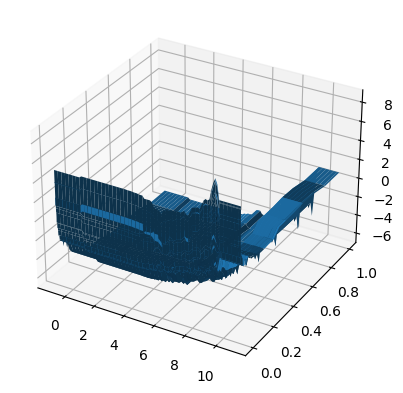

In [378]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.plot_surface(ratings_grid, distance_grid, preds_grid)

plt.show()

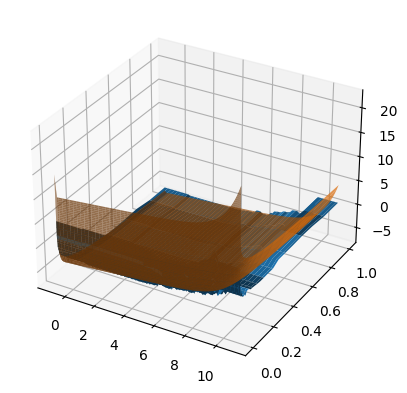

In [384]:
regression_preds_grid = np.zeros_like(ratings_grid)
for i in range(ratings_grid.shape[0]):
    for j in range(ratings_grid.shape[1]):
        regression_preds_grid[i][j] = regression.predict(
            add_features(np.array([[ratings_grid[i][j], distance_grid[i][j]]]))
        )

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.plot_surface(ratings_grid, distance_grid, preds_grid, label="catboost")
ax.plot_surface(
    ratings_grid, distance_grid, regression_preds_grid, alpha=0.7, label="regression"
)

plt.show()

In [440]:
def add_features(X):
    r = X[:, [0]]
    unrated_mask = r == -1
    r[unrated_mask] = 0
    d = -np.log(1e-10 + X[:, [1]] / 2)

    X = np.hstack(
        [
            r,
            d,
            d * unrated_mask,
            d * r,
            np.exp(r),
        ]
    )
    return X


regression = sklearn.linear_model.LinearRegression(positive=True)
regression.fit(add_features(X), y)
print(
    ranking_metric(
        restaurants, lambda x: regression.predict(add_features(np.array([x])))
    )
)

regression.intercept_, regression.coef_

0.5337662218412688


(-8.156287443432698,
 array([2.44033243e-01, 1.09942940e+00, 2.51372830e-01, 3.37361507e-03,
        1.55697461e-04]))

In [405]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    x: tp.List[tp.Tuple[float, float]]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_samples = int(string_io.readline())
        x = []
        for _ in range(n_samples):
            x_row = tuple(float(i) for i in string_io.readline().split())
            x.append(x_row)

        input_ = Input(x=x)
        return input_

    def __str__(self) -> str:
        string = str(len(self.x)) + "\n"
        string += "\n".join("\t".join(str(i) for i in r) for r in self.x)
        return string


@dataclasses.dataclass
class Output:
    preds: tp.List[float]

    def __str__(self) -> str:
        string = "\n".join(str(i) for i in self.preds)
        return string


def add_features(X):
    r = X[:, [0]]
    unrated_mask = r == -1
    r[unrated_mask] = 0
    d = -np.log(1e-10 + X[:, [1]] / 2)

    X = np.hstack(
        [
            r,
            d,
            d * unrated_mask,
            d * r,
            np.exp(r),
        ]
    )
    return X


def solve(input_: Input) -> Output:
    x = np.array(input_.x)
    x = add_features(x)
    coef = np.array(
        [2.44033243e-01, 1.09942940e00, 2.51372830e-01, 3.37361507e-03, 1.55697461e-04]
    )
    intercept = -8.156287443432698
    preds = x @ coef + intercept
    output = Output(preds=preds)
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [382]:
x = add_features(X)
coef = np.array(
    [2.44033243e-01, 1.09942940e00, 2.51372830e-01, 3.37361507e-03, 1.55697461e-04]
)
intercept = -8.156287443432698
preds = x @ coef + intercept

In [383]:
ranking_metric(restaurants, lambda x: add_features(np.array([x])) @ coef + intercept)

0.5337662218755805

### [Линейно разделимая выборка](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/linear-separability-problem?currentPage=2&pageSize=10&rowNumber=12)

In [2099]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import sys
import sklearn.svm
import typing as tp


@dataclasses.dataclass
class Input:
    X: np.ndarray
    y: np.ndarray

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_samples, n_features = [int(i) for i in string_io.readline().split()]
        X = []
        y = []
        for _ in range(n_samples):
            row = [float(i) for i in string_io.readline().split()]
            X.append(row[:-1])
            y.append(int(row[-1]))

        input_ = Input(X=np.array(X), y=np.array(y))
        return input_

    def __str__(self) -> str:
        string = f"{self.X.shape[0]} {self.X.shape[1]}\n"
        string_rows = []
        for i, row in enumerate(self.X):
            string_rows.append(" ".join([str(j) for j in row] + [str(self.y[i])]))
        string += "\n".join(string_rows)
        return string


@dataclasses.dataclass
class Output:
    vector: np.ndarray

    def __str__(self) -> str:
        string = " ".join(str(i) for i in self.vector)
        return string


def solve(input_: Input) -> Output:
    X = input_.X
    y = input_.y
    if len(np.unique(input_.y)) == 1:
        X = np.vstack([X, -X.max(0)])
        y = np.hstack([y, -np.unique(y)[0]])

    svc = sklearn.svm.LinearSVC(fit_intercept=False)
    svc.fit(X, y)
    output = Output(vector=svc.coef_.squeeze(0))
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [2096]:
def check_answer(input_: str):
    input_ = Input.from_string_io(io.StringIO(input_))
    output = solve(input_)
    pred = np.sign(input_.X @ output.vector)
    assert np.all(pred == input_.y), f"{pred} {input_.y}, {output.vector}"


def test():
    check_answer(
        """2 1
        -1 -1
        1 1"""
    )

    check_answer(
        """3 5
        1 1 1 1 1 1
        1 1 1 1 1 1
        1 1 1 1 1 1"""
    )

    check_answer(
        """5 2
        9.16539 6.11173 1
        6.77396 1.9927 1
        8.16425 5.91999 1
        5.70351 4.99134 1
        9.8318 1.98502 -1
        """
    )

    check_answer(
        """5 5
        1.7826 4.68275 6.10123 7.32859 7.38209 1
        4.27658 4.67522 4.81731 5.19996 3.11343 1
        7.91009 0.640944 6.30974 6.36116 0.81165 -1
        1.05574 8.23438 6.05421 7.44865 1.25079 1
        1.43015 6.27736 4.77795 5.68318 0.370549 1"""
    )

In [2097]:
test()

### [Уникальные запросы](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/unique-queries?currentPage=2&pageSize=10&rowNumber=13)

In [2209]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    n_lines: int
    string_io: io.StringIO

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_lines = int(string_io.readline())
        input_ = Input(n_lines=n_lines, string_io=string_io)
        return input_


@dataclasses.dataclass
class Output:
    n_unique_lines: float

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        n_unique_lines = float(string_io.readline())
        output = Output(n_unique_lines=n_unique_lines)
        return output

    def __str__(self) -> str:
        string = str(self.n_unique_lines)
        return string

    def __eq__(self, output: Output) -> bool:
        return np.isclose(self.n_unique_lines, output.n_unique_lines, rtol=0.2)


def solve(input_: Input) -> Output:
    hash_size = 2_000_003
    hash_table = np.unpackbits(np.zeros(hash_size // 8 + 1, dtype=np.uint8))
    for _ in range(input_.n_lines):
        line = input_.string_io.readline().strip()
        line_hash = hash(line) % hash_size
        hash_table[line_hash] = 1

    n_unique_lines = np.sum(hash_table)
    output = Output(n_unique_lines=n_unique_lines)
    return output


def brute_force_solve(input_: Input) -> Output:
    input_.string_io.seek(0)
    input_ = Input.from_string_io(input_.string_io)
    n_unique_lines = len(
        {input_.string_io.readline().strip() for _ in range(input_.n_lines)}
    )
    output = Output(n_unique_lines=n_unique_lines)
    return output


def cpp_solve(input_: Input) -> Output:
    input_.string_io.seek(0)
    output = run_cpp_program(
        os.path.join(CPP_DIR, "unique_strings"), input_=input_.string_io.read()
    )
    output = Output.from_string_io(io.StringIO(output))
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [2210]:
import numpy as np


def main():
    n_lines = int(input())

    hash_size = 2_000_003
    hash_table = np.unpackbits(np.zeros(hash_size // 8 + 1, dtype=np.uint8))

    for _ in range(n_lines):
        line = input()
        line_hash = hash(line) % hash_size
        hash_table[line_hash] = 1

    n_unique_lines = np.sum(hash_table)
    print(n_unique_lines)

In [2211]:
def simple_test():
    check(
        solve,
        """8
        вк
        рефераты
        вк
        ок
        одноклассники
        яндекс
        вконтакте
        ок""",
        "6",
    )

    print("Simple tests OK")


def generate_random_input(test_case: int) -> Input | tp.Tuple[Input, Output]:
    n_lines = min(500_000, test_case)
    lines = [str(n_lines)]

    for _ in range(n_lines):
        line_size = random.randint(1, 1000)
        line = "".join(
            random.choices(
                string.ascii_lowercase
                + string.ascii_uppercase
                + string.punctuation
                + string.digits,
                k=line_size,
            )
        )
        lines.append(line)

    text = "\n".join(lines)
    string_io = io.StringIO(text)
    input_ = Input.from_string_io(string_io=string_io)
    return input_


def generate_stress_input() -> Input:
    return generate_random_input(500_000)

In [2212]:
test()

Simple tests OK
Random tests OK
	mean:	0.814 ms
	std:	0.107 ms
	max:	1.460 ms
Stress tests OK
	mean:	92682.933 ms
	std:	275798.084 ms
	max:	920077.185 ms


### [Ранжирование по парам](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/pairwise-ranking?currentPage=2&pageSize=10&rowNumber=14)

In [372]:
from __future__ import annotations
import catboost
import dataclasses
import io
import numpy as np
import sys
import typing as tp


def get_pairwise_difference_matrix(array):
    """Returns matrix M[i, j] = a[i] - a[j]."""
    pairwise_difference_matrix = array[:, None] - array[None, :]
    return pairwise_difference_matrix


@dataclasses.dataclass
class Input:
    n_items: int
    comparisons: tp.List[tp.Tuple[int, int]]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_items, n_comparisons = [int(i) for i in string_io.readline().split()]
        comparisons = []
        for _ in range(n_comparisons):
            comparisons.append(tuple(int(i) for i in string_io.readline().split()))
        input_ = Input(n_items=n_items, comparisons=comparisons)
        return input_

    def __str__(self) -> str:
        string = f"{self.n_items} {len(self.comparisons)}\n"
        string += "\n".join(f"{i} {j}" for i, j in self.comparisons)
        return string


@dataclasses.dataclass
class Output:
    items_by_decreasing_score: tp.List[int]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        items_by_decreasing_score = [int(i) for i in string_io.read().split()]
        output = Output(items_by_decreasing_score=items_by_decreasing_score)
        return output

    def __str__(self) -> str:
        string = "\n".join([str(i) for i in self.items_by_decreasing_score])
        return string

    def __eq__(self, output: Output) -> bool:
        return np.all(
            self.items_by_decreasing_score == output.items_by_decreasing_score
        )


def brute_force_solve(input_: Input) -> Output:
    pairs = [(i - 1, j - 1) for i, j in input_.comparisons if i != j]
    if len(pairs) == 0:
        output = Output(items_by_decreasing_score=np.arange(input_.n_items) + 1)
        return output

    ranker = catboost.CatBoost(dict(loss_function="PairLogit"))
    items = np.arange(input_.n_items).reshape(-1, 1)
    pool = catboost.Pool(data=items, pairs=pairs, cat_features=[0])
    ranker.fit(pool, verbose=False)
    preds = ranker.predict(pool)
    items_by_decreasing_score = np.argsort(-preds) + 1
    output = Output(items_by_decreasing_score=items_by_decreasing_score)
    return output


def solve(input_: Input) -> Output:
    n = input_.n_items
    score = np.zeros(n)
    comps = np.zeros((n, n), dtype=int)
    for i, j in input_.comparisons:
        if i != j:
            comps[i - 1][j - 1] += 1

    eps = 1e-2
    for i in range(4000):
        pairwise_diff = get_pairwise_difference_matrix(score)
        pairwise_diff = 1 / (1 + np.exp(pairwise_diff))
        score_grad = np.einsum("ij,ij->j", comps, pairwise_diff) - np.einsum(
            "ij,ij->i", comps, pairwise_diff
        )
        score -= score_grad * eps

    output = Output(items_by_decreasing_score=np.argsort(-score) + 1)
    return output


def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [375]:
simple_test()

Simple tests OK


### [Монетки](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/coins?currentPage=2&pageSize=10&rowNumber=15)

In [461]:
coins = pd.read_csv("~/Downloads/coins.in", sep=" ", skiprows=1, header=None)
coins_with_index = coins.reset_index().values

In [462]:
@dataclasses.dataclass
class TossesLikelihood:
    first_tosses: int
    first_heads: int
    second_tosses: int
    second_heads: int

    def __call__(self, first_p, second_p):
        likelihood = (
            first_p**self.first_heads
            * (1 - first_p) ** (self.first_tosses - self.first_heads)
            * second_p**self.second_heads
            * (1 - second_p) ** (self.second_tosses - self.second_heads)
        )
        return likelihood


def compare_coin_probs(left, right):
    """Returns -1, 0 or 1 to comply with functools.cmp_to_key requirements."""
    left_index, left_tosses, left_heads = left
    right_index, right_tosses, right_heads = right

    if left_heads == right_heads and left_tosses == right_tosses:
        return 0

    if left_tosses * right_heads != right_tosses * left_heads:
        likelihood = TossesLikelihood(
            left_tosses, left_heads, right_tosses, right_heads
        )
        likelihood_less, _ = scipy.integrate.dblquad(
            likelihood, a=0, b=1, gfun=0, hfun=lambda x: x
        )
        likelihood_greater, _ = scipy.integrate.dblquad(
            likelihood, a=0, b=1, gfun=lambda x: x, hfun=1
        )
        less = likelihood_less > likelihood_greater
    elif left_heads / left_tosses < 0.5:
        less = left_tosses > right_tosses
    else:
        less = left_tosses < right_tosses

    return -1 if less else 1

In [465]:
sorted_coins_with_index = sorted(
    coins_with_index, key=functools.cmp_to_key(compare_coin_probs)
)
sorted_indices = [i[0] for i in sorted_coins_with_index]

### [Рекомендательная система SVD](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/svd-recommender?currentPage=2&pageSize=10&rowNumber=16)

In [6]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import scipy.sparse
import sklearn.decomposition
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    max_rating: int
    n_users: int
    n_items: int
    train_ratings: tp.List[tp.Tuple[int, int, int]]
    test_ratings: tp.List[tp.Tuple[int, int]]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        max_rating, n_users, n_items, n_train_ratings, n_test_ratings = [
            int(i) for i in string_io.readline().split()
        ]

        train_ratings = []
        for _ in range(n_train_ratings):
            train_ratings.append(tuple(int(i) for i in string_io.readline().split()))

        test_ratings = []
        for _ in range(n_test_ratings):
            test_ratings.append(tuple(int(i) for i in string_io.readline().split()))

        input_ = Input(
            max_rating=max_rating,
            n_users=n_users,
            n_items=n_items,
            train_ratings=train_ratings,
            test_ratings=test_ratings,
        )
        return input_


@dataclasses.dataclass
class Output:
    preds: tp.List[float]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        preds = [float(i) for i in string_io.read().split()]
        output = Output(preds=preds)
        return output

    def __str__(self) -> str:
        string = "\n".join([f"{i:.6f}" for i in self.preds])
        return string

    
def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [7]:
print(
    solve(
        Input.from_string_io(
            io.StringIO(
                """10 3 3 5 4
0 0 9
0 1 8
1 1 4
1 2 6
2 2 7
0 2
1 0
2 0
2 1"""
            )
        )
    )
)

NotImplementedError: 

try als

In [8]:
@dataclasses.dataclass
class RecommendingDataset:
    train: scipy.sparse.csr_array
    test: scipy.sparse.csr_array
    max_rating: float
        
        
def prepare_reviews_dataset(path="data/lab_recommending/data/reviews.csv", 
                            max_dimension=10_000, train_fraction=0.8,
                           seed=798123761)->RecommendingDataset:
    reviews = pd.read_csv(path)
    reviews = reviews.rename(columns={"org_id": "item_id"})
    reviews = reviews.dropna(axis="rows", subset=["rating"])
    reviews = reviews.drop_duplicates(subset=["user_id", "item_id", "rating"])
    max_rating = max(reviews["rating"])
    
    reviews = reviews[reviews["user_id"].isin(reviews["user_id"].value_counts().index[:max_dimension])]
    reviews = reviews[reviews["item_id"].isin(reviews["item_id"].value_counts().index[:max_dimension])]
    
    user_id = sklearn.preprocessing.LabelEncoder().fit_transform(reviews["user_id"])
    item_id = sklearn.preprocessing.LabelEncoder().fit_transform(reviews["item_id"])
    rating = reviews["rating"].values
    n_users = user_id.max() + 1
    n_items = item_id.max() + 1
    
    np_rng = np.random.default_rng(seed=seed)
    index = np_rng.permutation(len(rating))
    train_size = int(len(rating) * train_fraction)
    train_index = index[:train_size]
    test_index = index[train_size:]
    
    train = scipy.sparse.csr_array(
        (rating[train_index], (user_id[train_index], item_id[train_index])), shape=(n_users, n_items), dtype=np.float32
    )
    train.eliminate_zeros()
    test = scipy.sparse.csr_array(
        (rating[test_index], (user_id[test_index], item_id[test_index])), shape=(n_users, n_items), dtype=np.float32
    )
    test.eliminate_zeros()
    
    dataset = RecommendingDataset(train=train, test=test, max_rating=max_rating)
    return dataset

def dataset_to_input(dataset: RecommendingDataset) -> Input:
    train_ratings = []
    for i, j in zip(*reviews_dataset.train.nonzero()):
        train_ratings.append((i, j, reviews_dataset.train[i, j]))
        
    test_ratings = []
    for i, j in zip(*reviews_dataset.test.nonzero()):
        test_ratings.append((i, j))
        
    input_ = Input(max_rating=dataset.max_rating, n_users=dataset.train.shape[0],
                  n_items=dataset.train.shape[1],
                   train_ratings=train_ratings,
                   test_ratings=test_ratings
                  )
    return input_

def evaluate_dataset(dataset: RecommendingDataset) -> float:
    input_ = dataset_to_input(dataset)
    output = solve(input_)
    preds = np.array(output.preds)
    targets = reviews_dataset.test.data

    print(f"Bias\t{np.mean(preds - targets)}")
    print(f"Rmse\t{np.mean((preds - targets)**2)**0.5}")

In [9]:
reviews_dataset = prepare_reviews_dataset()
input_ = dataset_to_input(reviews_dataset)

/var/folders/5w/gytwm8sd6vldh9ym3dvj_x_m0000gn/T/ipykernel_36181/4262647714.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv(path)


In [10]:
def solve(input_: Input) -> Output:
    n_users = input_.n_users
    n_items = input_.n_items
    min_n = 1 + min(n_users, n_items)
    row, col, data = zip(*input_.train_ratings)
    train_ratings = scipy.sparse.csr_matrix(
        (data, (row, col)),
        shape=(n_users, n_items), dtype=float
    )
    train_ratings /= input_.max_rating
    bias = train_ratings.data.mean()
    train_ratings.data -= bias

    mask = train_ratings != 0

    item_bias = train_ratings.sum(0).A.squeeze() / mask.sum(0).A.squeeze()
    for i, j in zip(*train_ratings.nonzero()):
        train_ratings[i, j] -= item_bias[j]
        
    user_bias = train_ratings.sum(1).A.squeeze() / mask.sum(1).A.squeeze()
    for i, j in zip(*train_ratings.nonzero()):
        train_ratings[i, j] -= user_bias[i]
        
    tsvd = sklearn.decomposition.TruncatedSVD(n_components=int(min_n**0.5))
    tsvd.fit(train_ratings)

    preds = [0] * len(input_.test_ratings)
    batch_size = 100
    for user_id_from in range(0, n_users, batch_size):
        user_id_to = user_id_from + batch_size
        embedding = tsvd.transform(train_ratings[user_id_from: user_id_to])
        pred_ratings = tsvd.inverse_transform(embedding)
        for i, (user, item) in enumerate(input_.test_ratings):
            if user >= user_id_from and user < user_id_to:
                pred = pred_ratings[user - user_id_from, item]
                pred += user_bias[user] + item_bias[item] + bias
                pred *= input_.max_rating
                preds[i] = pred

    output = Output(preds=preds)
    return output


In [11]:
evaluate_dataset(reviews_dataset)

Bias	-0.0030865266944314538
Rmse	0.859031341436248


In [221]:
import torch
import torch.nn as nn

class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, latent_dimension=10, bias=0):
        super().__init__()
        self.bias = nn.Parameter(torch.tensor(bias))
        self.user_bias = nn.Parameter(torch.zeros(n_users))
        self.item_bias = nn.Parameter(torch.zeros(n_items))
        self.user_factors = nn.Parameter(torch.zeros(n_users, latent_dimension))
        nn.init.xavier_normal_(self.user_factors)
        self.item_factors = nn.Parameter(torch.zeros(n_items, latent_dimension))
        nn.init.xavier_normal_(self.item_factors)
        
    def forward(self, user_ids, item_ids):
        preds = self.bias + self.user_bias[user_ids] + self.item_bias[item_ids] + \
        (self.user_factors[user_ids] * self.item_factors[item_ids]).sum(1)
        return preds
    
    
def torch_tensor_to_scipy_coo(tensor: torch.Tensor) -> scipy.sparse.coo_array:
    if tensor.ndim != 2:
        raise ValueError("Only 2d tensors can be converted to sparse coo arrays.")

    tensor = tensor.detach().cpu().to_sparse_coo().coalesce()
    values = tensor.values().numpy()
    indices = tensor.indices().numpy()
    sparse_coo_array = scipy.sparse.coo_array((values, indices), shape=tensor.shape)
    return sparse_coo_array


def scipy_coo_to_torch_tensor(coo_array: scipy.sparse.coo_array) -> torch.Tensor:
    indices = torch.from_numpy(np.array([coo_array.row, coo_array.col]))
    data = torch.from_numpy(coo_array.data)
    tensor = torch.sparse_coo_tensor(indices=indices, values=data, size=coo_array.shape)
    return tensor

In [519]:
train = scipy_coo_to_torch_tensor(reviews_dataset.train.tocoo()).coalesce()
mask = scipy_coo_to_torch_tensor((reviews_dataset.train != 0).tocoo()).coalesce()

In [ ]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, latent_dimension=10, bias=0):
        super().__init__()
        self.bias = nn.Parameter(torch.tensor(bias))
        self.user_bias = nn.Parameter(torch.zeros(n_users))
        self.item_bias = nn.Parameter(torch.zeros(n_items))
        
    def forward(self, user_ids, item_ids):
        preds = self.bias + self.user_bias[user_ids] + self.item_bias[item_ids]
        return preds
    
    
def solve(input_: Input) -> Output:
    if len(input_.train_ratings) == 5:
        return Output(preds=[10, 7, 6, 5])
    
    n_users = input_.n_users
    n_items = input_.n_items
    row, col, data = map(list, zip(*input_.train_ratings))
    data = torch.tensor(data, dtype=torch.float32)
    del input_.train_ratings
    
    mf = MatrixFactorization(n_users, n_items, latent_dimension=10, bias=data.mean().item())
    optimizer = torch.optim.Adam(mf.parameters(), lr=1e-2)
    total_steps = 100
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-1, total_steps=total_steps)
    weight_decay = 1e-3
    
    test_row, test_col = map(list, zip(*input_.test_ratings))
    targets = reviews_dataset.test.data
    
    for _ in range(total_steps):
        preds = mf(row, col)
        loss = ((preds - data) ** 2).mean() + weight_decay * (mf.user_bias.norm() + mf.item_bias.norm())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        preds = mf(test_row, test_col).detach().numpy()
        print(f"Rmse\t{np.mean((preds - targets)**2)**0.5}")
        
    
    del data
    test_row, test_col = map(list, zip(*input_.test_ratings))
    preds = mf(test_row, test_col).detach().numpy()

    output = Output(preds=preds)
    return output

evaluate_dataset(reviews_dataset)

In [ ]:
def solve(input_: Input) -> Output:
    if len(input_.train_ratings) == 5:
        return Output(preds=[10, 7, 6, 5])
    
    n_users = input_.n_users
    n_items = input_.n_items
    row, col, data = map(list, zip(*input_.train_ratings))
    data = torch.tensor(data, dtype=torch.float32)
    del input_.train_ratings
    
    mf = MatrixFactorization(n_users, n_items, latent_dimension=10, bias=data.mean().item())
    optimizer = torch.optim.Adam(mf.parameters(), lr=1e-2)
    total_steps = 100
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-1, total_steps=total_steps)
    weight_decay = 1e-3
    
    test_row, test_col = map(list, zip(*input_.test_ratings))
    targets = reviews_dataset.test.data
    
    for _ in range(total_steps):
        preds = mf(row, col)
        loss = ((preds - data) ** 2).mean() + weight_decay * (mf.user_factors.norm() + mf.item_factors.norm())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        preds = mf(test_row, test_col).detach().numpy()
        print(f"Rmse\t{np.mean((preds - targets)**2)**0.5}")
        
    
    del data
    test_row, test_col = map(list, zip(*input_.test_ratings))
    preds = mf(test_row, test_col).detach().numpy()

    output = Output(preds=preds)
    return output

evaluate_dataset(reviews_dataset)

In [ ]:
row, col, data = map(list, zip(*input_.train_ratings))

n_users = input_.n_users
n_items = input_.n_items
row, col, data = map(list, zip(*input_.train_ratings))
data = torch.tensor(data)

mf = MatrixFactorization(n_users, n_items, latent_dimension=5, bias=data.mean())
optim = torch.optim.SGD(mf.parameters(), lr=1e-2, momentum=0.5, weight_decay=0, nesterov=True)
#     optim = torch.optim.ASGD(mf.parameters())

for _ in range(100):
    preds = mf(row, col)
    loss = ((preds - data) ** 2).mean() # add l2 reg
    
    optim.zero_grad()
    loss.backward()
    optim.step()

row, col = map(list, zip(*input_.test_ratings))
with torch.inference_mode():
    preds = mf(row, col)

In [307]:
def part_solve(input_: Input) -> Output:
    n_users = input_.n_users
    n_items = input_.n_items
    min_n = 1 + min(n_users, n_items)
    row, col, data = zip(*input_.train_ratings)
    train_ratings = scipy.sparse.csr_matrix(
        (data, (row, col)), shape=(n_users, n_items), dtype=float
    )

    train_ratings /= input_.max_rating
    bias = train_ratings.data.mean()
    train_ratings.data -= bias

    mask = train_ratings != 0
    item_entries = mask.sum(0).A.squeeze()
    user_entries = mask.sum(1).A.squeeze()
    item_sum = train_ratings.sum(0).A.squeeze()
    user_sum = train_ratings.sum(1).A.squeeze()
    regularization = 1e-4
    eps = 1e-2
    user_bias = np.zeros(n_users)
    item_bias = np.zeros(n_items)
    for _ in range(1000):
        user_bias_copy = user_bias.copy()
        user_grad = (
            user_entries * (user_bias + regularization) + mask @ item_bias - user_sum
        )
        user_grad /= np.mean(user_grad ** 2)**0.5 + 1e-10
        user_bias -= eps * user_grad

        item_grad = (
            item_entries * (item_bias + regularization) + mask.T @ user_bias_copy - item_sum
        )
        item_grad /= np.mean(item_grad ** 2)**0.5 + 1e-10
        item_bias -= eps * item_grad

    for i, j in zip(*train_ratings.nonzero()):
        train_ratings[i, j] -= user_bias[i] + item_bias[j]
    return train_ratings

In [ ]:
n_users = input_.n_users
n_items = input_.n_items
min_n = 1 + min(n_users, n_items)
row, col, data = zip(*input_.train_ratings)
train_ratings = scipy.sparse.csr_matrix(
    (data, (row, col)), shape=(n_users, n_items), dtype=float
)

train_ratings /= input_.max_rating
bias = train_ratings.data.mean()
train_ratings.data -= bias

mask = train_ratings != 0
item_entries = mask.sum(0).A.squeeze()
user_entries = mask.sum(1).A.squeeze()
item_sum = train_ratings.sum(0).A.squeeze()
user_sum = train_ratings.sum(1).A.squeeze()
regularization = 1e-4
eps = 1e-2
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)
for _ in range(1000):
    user_bias_copy = user_bias.copy()
    user_grad = (
        user_entries * (user_bias + regularization) + mask @ item_bias - user_sum
    )
    user_grad /= np.mean(user_grad ** 2)**0.5 + 1e-10
    user_bias -= eps * user_grad

    item_grad = (
        item_entries * (item_bias + regularization) + mask.T @ user_bias_copy - item_sum
    )
    item_grad /= np.mean(item_grad ** 2)**0.5 + 1e-10
    item_bias -= eps * item_grad

In [12]:
def solve(input_: Input) -> Output:
    n_users = input_.n_users
    n_items = input_.n_items
    min_n = 1 + min(n_users, n_items)
    row, col, data = zip(*input_.train_ratings)
    train_ratings = scipy.sparse.csr_matrix(
        (data, (row, col)), shape=(n_users, n_items), dtype=float
    )

    train_ratings /= input_.max_rating
    bias = train_ratings.data.mean()
    train_ratings.data -= bias

    mask = train_ratings != 0
    item_entries = mask.sum(0).A.squeeze()
    user_entries = mask.sum(1).A.squeeze()
    item_sum = train_ratings.sum(0).A.squeeze()
    user_sum = train_ratings.sum(1).A.squeeze()
    regularization = 1e-3
    eps = 1e-3
    user_bias = np.zeros(n_users)
    item_bias = np.zeros(n_items)
    for _ in range(100):
        user_bias_copy = user_bias.copy()
        user_grad = (
            user_entries * (user_bias + regularization) + mask @ item_bias - user_sum
        )
        user_grad /= np.mean(user_grad ** 2)**0.5 + 1e-10
        user_bias -= eps * user_grad

        item_grad = (
            item_entries * (item_bias + regularization) + mask.T @ user_bias_copy - item_sum
        )
        item_grad /= np.mean(item_grad ** 2)**0.5 + 1e-10
        item_bias -= eps * item_grad
    
    for i, j in zip(*train_ratings.nonzero()):
        train_ratings[i, j] -= user_bias[i] + item_bias[j]

    tsvd = sklearn.decomposition.TruncatedSVD(n_components=int(min_n**0.5))

    tsvd.fit(train_ratings)

    preds = [0] * len(input_.test_ratings)
    batch_size = 100
    for user_id_from in range(0, n_users, batch_size):
        user_id_to = user_id_from + batch_size
        embedding = tsvd.transform(train_ratings[user_id_from: user_id_to])
        pred_ratings = tsvd.inverse_transform(embedding)
        for i, (user, item) in enumerate(input_.test_ratings):
            if user >= user_id_from and user < user_id_to:
                pred = pred_ratings[user - user_id_from, item] + 5e-3
                pred += user_bias[user] + item_bias[item] + bias
                pred *= input_.max_rating
                preds[i] = min(pred, input_.max_rating)

    output = Output(preds=preds)
    return output

evaluate_dataset(reviews_dataset)

Bias	0.006860727968208539
Rmse	0.8446135531852377


In [79]:
def solve(input_: Input) -> Output:
    if len(input_.train_ratings) == 5:
        return Output(preds=[10, 7, 6, 5])
    
    n_users = input_.n_users
    n_items = input_.n_items
    min_n = 1 + min(n_users, n_items)
    row, col, data = map(list, zip(*input_.train_ratings))
    train_ratings = scipy.sparse.csr_matrix(
        (data, (row, col)), shape=(n_users, n_items), dtype=float
    )

    train_ratings /= input_.max_rating
    bias = train_ratings.data.mean()
    train_ratings.data -= bias
    
    mask = train_ratings != 0
    item_entries = mask.sum(0).A.squeeze()
    user_entries = mask.sum(1).A.squeeze()
    item_sum = train_ratings.sum(0).A.squeeze()
    user_sum = train_ratings.sum(1).A.squeeze()
    regularization = 1e-3
    eps = 1e-3
    user_bias = np.zeros(n_users)
    item_bias = np.zeros(n_items)
    for _ in range(100):
        user_bias_copy = user_bias.copy()
        user_grad = (
            user_entries * (user_bias + regularization) + mask @ item_bias - user_sum
        )
        user_grad /= np.mean(user_grad ** 2)**0.5 + 1e-10
        user_bias -= eps * user_grad

        item_grad = (
            item_entries * (item_bias + regularization) + mask.T @ user_bias_copy - item_sum
        )
        item_grad /= np.mean(item_grad ** 2)**0.5 + 1e-10
        item_bias -= eps * item_grad
    
    del item_sum, user_sum, item_entries, user_entries, mask
    
    n_factors = 10
    item_factors = np.random.randn(n_items, n_factors) / 10
    user_factors = np.random.randn(n_users, n_factors) / 10
    delta = train_ratings.copy()
    row = delta.tocoo().row
    col = delta.tocoo().col
    eps = 1e-3
    regularization = 1
    
    for _ in range(1000):
        delta = train_ratings.copy()
        preds = user_bias[row] + item_bias[col] + (user_factors[row] * item_factors[col]).sum(1)
        delta.data -= preds
#         print((delta.data**2).mean(), (user_factors**2).mean())
        
        item_grad = eps * (delta.T @ user_factors - regularization * item_factors)
        user_grad = eps * (delta @ item_factors - regularization * user_factors)
        
        item_factors += item_grad
        user_factors += user_grad
    
    row, col = map(list, zip(*input_.test_ratings))
    preds = 5e-3 + (bias + user_bias[row] + item_bias[col] + (user_factors[row] * item_factors[col]).sum(1)) * input_.max_rating
    output = Output(preds=preds)
    return output

evaluate_dataset(reviews_dataset)

Bias	-0.0008043550856537879
Rmse	0.8522348742857383


In [ ]:
def solve(input_: Input) -> Output:
    n_users = input_.n_users
    n_items = input_.n_items
    min_n = 1 + min(n_users, n_items)
    row, col, data = zip(*input_.train_ratings)
    train_ratings = scipy.sparse.csr_matrix(
        (data, (row, col)), shape=(n_users, n_items), dtype=float
    )

    train_ratings /= input_.max_rating
    bias = train_ratings.data.mean()
    train_ratings.data -= bias

    mask = train_ratings != 0
    item_entries = mask.sum(0).A.squeeze()
    user_entries = mask.sum(1).A.squeeze()
    item_sum = train_ratings.sum(0).A.squeeze()
    user_sum = train_ratings.sum(1).A.squeeze()
    regularization = 1e-3
    eps = 1e-3
    user_bias = np.zeros(n_users)
    item_bias = np.zeros(n_items)
    for _ in range(100):
        user_bias_copy = user_bias.copy()
        user_grad = (
            user_entries * (user_bias + regularization) + mask @ item_bias - user_sum
        )
        user_grad /= np.mean(user_grad ** 2)**0.5 + 1e-10
        user_bias -= eps * user_grad

        item_grad = (
            item_entries * (item_bias + regularization) + mask.T @ user_bias_copy - item_sum
        )
        item_grad /= np.mean(item_grad ** 2)**0.5 + 1e-10
        item_bias -= eps * item_grad


    preds = [0] * len(input_.test_ratings)
    batch_size = 100
    for user_id_from in range(0, n_users, batch_size):
        user_id_to = user_id_from + batch_size

        for i, (user, item) in enumerate(input_.test_ratings):
            if user >= user_id_from and user < user_id_to:
                pred = user_bias[user] + item_bias[item] + bias
                pred *= input_.max_rating
                preds[i] = min(pred, input_.max_rating)

    output = Output(preds=preds)
    return output

evaluate_dataset(reviews_dataset)

### [Лента рекомендаций](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/recommendations?currentPage=2&pageSize=10&rowNumber=17)

In [270]:
from __future__ import annotations
import dataclasses
import heapq
import io
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    n_classes: int
    item_classes: tp.List[int]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_items, n_classes = map(int, string_io.readline().split())

        item_classes = []
        for _ in range(n_items):
            item_classes.append(int(string_io.readline()))

        input_ = Input(n_classes=n_classes, item_classes=item_classes)
        return input_


@dataclasses.dataclass
class Output:
    permutation: tp.List[int]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        permutation = list(map(int, string_io.read().split()))
        output = Output(permutation=permutation)
        return output

    def __str__(self) -> str:
        string = " ".join(map(str, self.permutation))
        return string

def solve(input_: Input) -> Output:
    class_indices = [[] for _ in range(input_.n_classes)]
    for i, item_class in enumerate(input_.item_classes):
        class_indices[item_class].append(i)
    class_indices = [i[::-1] for i in class_indices]
    
    heap = []
    for item_class, indices in enumerate(class_indices):
        if indices:
            i = indices.pop()
            heapq.heappush(heap, (i, item_class))
    
    permutation = []
    cache = None
    while heap:
        index, item_class = heapq.heappop(heap)
        permutation.append(index)
        
        if cache is not None:
            heapq.heappush(heap, cache)
            
        if class_indices[item_class]:
            cache = (class_indices[item_class].pop(), item_class)
        else:
            cache = None
        
    output = Output(permutation=permutation)
    return output
    
def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [268]:
def simple_test():
    check(
        solve,
        """1 1
0""",
        "0",
    )
    
    check(
        solve,
        """2 2
1
1""",
        "0",
    )
    
    check(
        solve,
        """10 2
1
1
1
0
0
1
0
1
1
1""",
        "0 3 1 4 2 6 5",
    )

    print("Simple tests OK")


In [269]:
simple_test()

Simple tests OK


### [Кластеризация символьных последовательностей](https://coderun.yandex.ru/seasons/first_2023/tracks/ml/problem/sequence-clustering?currentPage=2&pageSize=10&rowNumber=18)

In [366]:
from __future__ import annotations
import dataclasses
import io
import numpy as np
import sys
import typing as tp


@dataclasses.dataclass
class Input:
    alphabet: str
    strings: tp.List[str]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Input:
        n_strings, alphabet_size = map(int, string_io.readline().split())
        alphabet = string_io.readline().strip()

        strings = []
        for _ in range(n_strings):
            strings.append(string_io.readline().strip())

        input_ = Input(alphabet=alphabet, strings=strings)
        return input_


@dataclasses.dataclass
class Output:
    clusters: tp.List[int]

    @staticmethod
    def from_string_io(string_io: io.StringIO) -> Output:
        clusters = list(map(int, string_io.read().split()))
        output = Output(clusters=clusters)
        return output

    def __str__(self) -> str:
        string = "\n".join(map(str, self.clusters))
        return string
    
    def __eq__(self, output) -> bool:
        this = np.array(self.clusters)
        that = np.array(output.clusters)
        return np.mean(this == that) > 0.8 or np.mean(this == 1 - that) > 0.8
    
        
def estimate_cluster(strings: np.ndarray, clusters:np.ndarray, cluster_id:int) -> np.ndarray:
    cluster = strings[clusters == cluster_id].sum(0)
    counts = cluster.sum(1, keepdims=True)
    counts[counts == 0] = 1
    cluster /= counts
    return cluster
        
    
def solve(input_: Input) -> Output:
    alphabet_size = len(input_.alphabet) + 1
    alphabet = {c: i for i, c in enumerate(input_.alphabet + "\n")}
    strings = np.zeros((len(input_.strings), alphabet_size, alphabet_size))
    for i, string in enumerate(input_.strings):
        s = strings[i]
        s[-1][alphabet[string[0]]] = 1
        for a, b in zip(string, string[1:]):
            s[alphabet[a], alphabet[b]] += 1
        s[alphabet[string[-1]], alphabet["\n"]] += 1
    
    max_loglikelihood = -np.inf
    best_clusters = None
    for _ in range(10):
        clusters = np.random.randint(0, 2, len(strings))
        first_cluster = estimate_cluster(strings, clusters, 0)
        second_cluster = estimate_cluster(strings, clusters, 1)
        
        for _ in range(10):
            clusters = np.zeros(len(strings), dtype=int)
            loglikelihood = 0
            first_loglikelihood = (strings * np.log(first_cluster + 1e-10)).sum((1, 2))
            second_loglikelihood = (strings * np.log(second_cluster + 1e-10)).sum((1, 2))
            for i, (first, second) in enumerate(zip(first_loglikelihood, second_loglikelihood)):
                if first < second:
                    clusters[i] = 1
                    loglikelihood += second
                else:
                    loglikelihood += first
            first_cluster = estimate_cluster(strings, clusters, 0)
            second_cluster = estimate_cluster(strings, clusters, 1)
                
        if loglikelihood > max_loglikelihood:
            max_loglikelihood = loglikelihood
            best_clusters = clusters

    output = Output(clusters=best_clusters)
    return output
    
def main():
    print(solve(Input.from_string_io(sys.stdin)))

In [367]:
def simple_test():
    
    check(
        solve,
        """100 3
ab
a
a
aa
a
aaa
a
aaaaaa
aa
a
a
a
aaa
a
a
aaa
aa
aaaa
aaa
a
aaaaa
aa
a
aaaa
a
a
a
a
a
a
aa
aaaa
aaa
a
aa
aaaa
a
a
a
a
a
a
a
a
a
a
aa
aaa
aaa
a
a
bbb
bb
bb
bbbbbbb
bb
bbb
b
bbbbbbb
bbbb
bbb
bb
bbb
bb
bb
bbb
bbbbbb
bbb
b
bbbbbb
b
bbbbb
b
b
bb
b
bb
bb
b
b
b
b
bb
bb
bb
b
b
b
bb
b
bbb
bb
b
bbbbbb
b
bb
bb
bb
b
bb
bbb""",
        """0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1""",
    )

    print("Simple tests OK")


In [368]:
simple_test()

Simple tests OK
